In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

from data_preprocessing import *
from models import SimpleCNN, ResNet
from models.utils import TestCallback
from cutout.cutout import DynamicCutoutLayer, RandomCutoutLayer
from cutout.utils import zero_out, zero_out_batched
# from cutout.mult_cutout import CutOut

2024-04-14 15:08:19.130463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 128
EPOCHS = 10

In [3]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'],
                                          as_supervised=True, with_info=True,
                                          shuffle_files=True)

INFO:absl:Load dataset info from /home/martin/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/martin/tensorflow_datasets/cifar10/3.0.2)
2024-04-14 15:08:22.975905: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from /home/martin/tensorflow_datasets/cifar10/3.0.2


In [4]:
label_names = info_ds.features['label'].names
print(label_names)
# tfds.show_examples(train_ds, info_ds, rows=1, cols=4)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='square')

train_data = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="train", cutout_layer=rnd_cutout))
val_data = train_ds.take(10000).apply(lambda ds:
                            prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="val"))
test_data = test_ds.apply(lambda ds:
                          prepare_dataset(ds, batch_size=BATCH_SIZE ,kind="test"))

2024-04-14 15:08:23.887368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 15:08:23.887840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 15:08:25.113201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

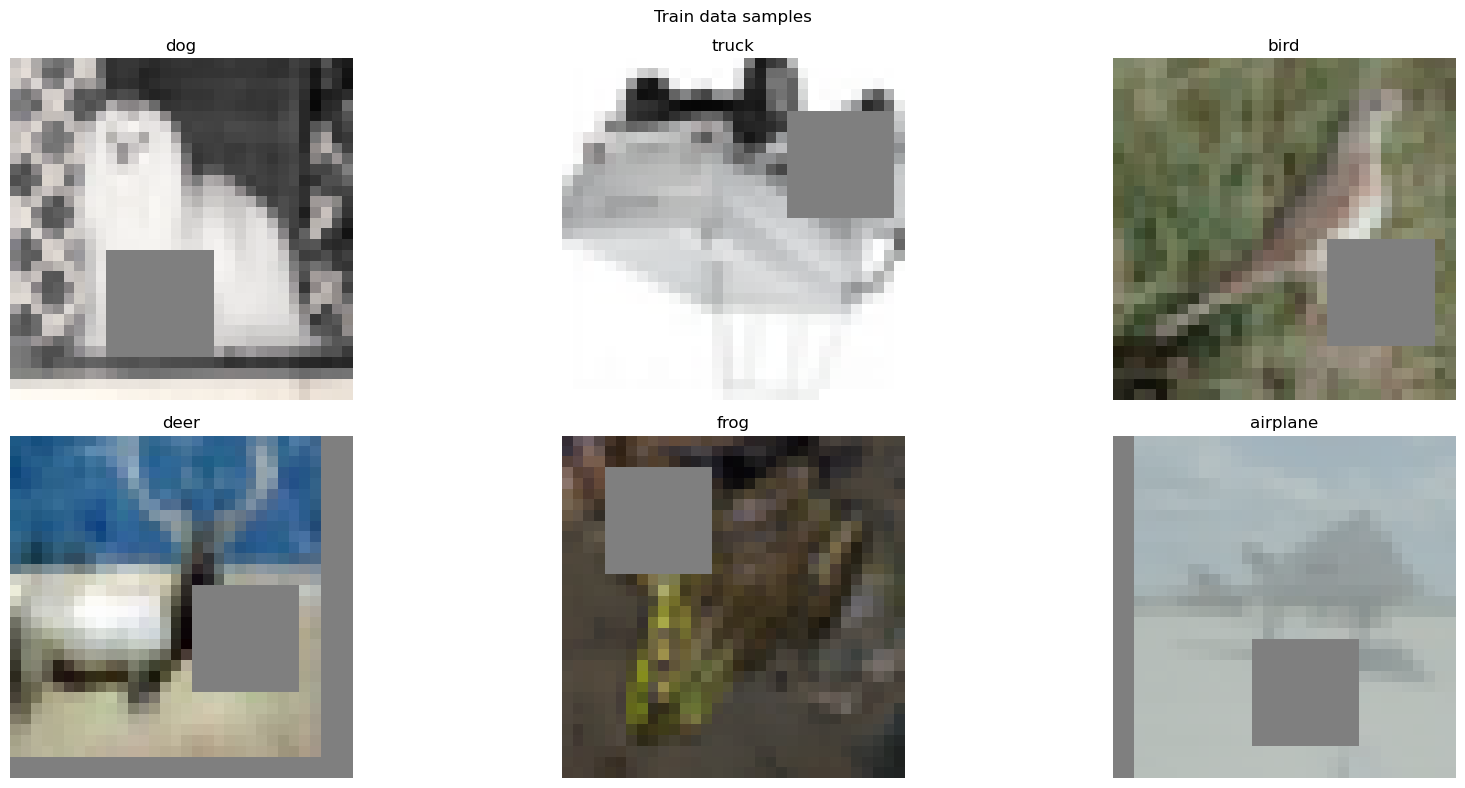

2024-04-14 15:08:25.419489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 15:08:25.419968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


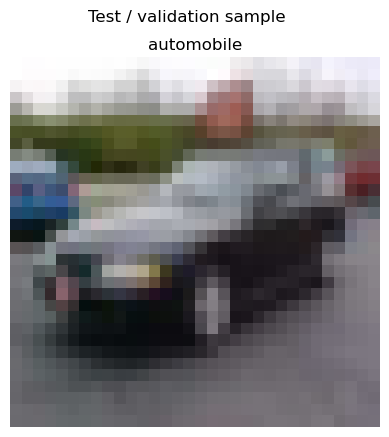

In [6]:
import matplotlib.pyplot as plt

# samples from train data
num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(train_data.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    label = label_names[np.argmax(label[0])]
    axes[i].set_title(label)
    axes[i].axis('off')
plt.tight_layout()
plt.show()
# image from test data
img_test, label_test = iter(test_data.take(1)).next()
plt.imshow((img_test[0] + 1) / 2)
plt.suptitle('Test / validation sample')
plt.title(f"{label_names[np.argmax(label_test[0])]}")
plt.axis('off')
plt.show()

In [7]:
simple_CNN = SimpleCNN()
simple_CNN.build((None, 32, 32, 3))  # Necessary to create the model's weights
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

res_net18 = ResNet((32, 32, 3), 10, type='resnet18')
res_net18.build((None, 32, 32, 3))
res_net18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net18.summary()

res_net34 = ResNet((32, 32, 3), 10, type='resnet34')
res_net34.build((None, 32, 32, 3))
res_net34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net34.summary()

In [8]:
# test with less data
train_split = train_data.take(10)
val_split = val_data.take(1)
test_split = test_data.take(10)
## -----------------------------------------------------------
test_res_callback_sCNN = TestCallback(test_data=test_split)
test_res_callback_res18 = TestCallback(test_data=test_split)
test_res_callback_res34 = TestCallback(test_data=test_split)

history_sCNN = simple_CNN.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_sCNN])
history_res18 = res_net18.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_res18])
history_res34 = res_net34.fit(train_split, epochs=EPOCHS, validation_data=val_split, callbacks=[test_res_callback_res34])

# Ensure the directory exists and save the model weights
os.makedirs('trained_models', exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S") 
simple_CNN.save_weights(f'trained_models/simpleCNN_{timestamp}.h5')
res_net18.save_weights(f'trained_models/resnet18_{timestamp}.h5')
res_net34.save_weights(f'trained_models/resnet34_{timestamp}.h5')

Epoch 1/10


2024-04-14 15:08:26.821608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-04-14 15:08:26.822083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 2.2517 - accuracy: 0.1586

2024-04-14 15:08:29.360065: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:29.501957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 15:08:29.503143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

Epoch 0: Testing loss: 2.1192028522491455, accuracy: 0.26249998807907104
10/10 [==============================] - 4s 246ms/step - loss: 2.2517 - accuracy: 0.1586 - val_loss: 2.1410 - val_accuracy: 0.2422 - epoch: 0.0000e+00 - test_loss: 2.1192 - test_accuracy: 0.2625
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.1747 - accuracy: 0.2016

2024-04-14 15:08:32.457342: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:32.931533: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 1.997620940208435, accuracy: 0.27421873807907104
10/10 [==============================] - 3s 203ms/step - loss: 2.1747 - accuracy: 0.2016 - val_loss: 1.9858 - val_accuracy: 0.3359 - epoch: 1.0000 - test_loss: 1.9976 - test_accuracy: 0.2742
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 2.1130 - accuracy: 0.2300

2024-04-14 15:08:34.993896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:35.431271: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2: Testing loss: 1.962241530418396, accuracy: 0.2984375059604645
10/10 [==============================] - 2s 168ms/step - loss: 2.1196 - accuracy: 0.2281 - val_loss: 2.0140 - val_accuracy: 0.2734 - epoch: 2.0000 - test_loss: 1.9622 - test_accuracy: 0.2984
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 2.0715 - accuracy: 0.2500

2024-04-14 15:08:37.720583: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:38.193470: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3: Testing loss: 1.916843056678772, accuracy: 0.31562501192092896
10/10 [==============================] - 3s 203ms/step - loss: 2.0715 - accuracy: 0.2500 - val_loss: 1.9221 - val_accuracy: 0.2969 - epoch: 3.0000 - test_loss: 1.9168 - test_accuracy: 0.3156
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 2.0378 - accuracy: 0.2867

2024-04-14 15:08:40.681268: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:41.135984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4: Testing loss: 1.8767856359481812, accuracy: 0.3515625
10/10 [==============================] - 3s 210ms/step - loss: 2.0378 - accuracy: 0.2867 - val_loss: 1.9335 - val_accuracy: 0.3594 - epoch: 4.0000 - test_loss: 1.8768 - test_accuracy: 0.3516
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 2.0059 - accuracy: 0.2797

2024-04-14 15:08:43.263984: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:43.715687: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5: Testing loss: 1.8056666851043701, accuracy: 0.37031251192092896
10/10 [==============================] - 3s 169ms/step - loss: 2.0059 - accuracy: 0.2797 - val_loss: 1.7106 - val_accuracy: 0.3984 - epoch: 5.0000 - test_loss: 1.8057 - test_accuracy: 0.3703
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 1.9844 - accuracy: 0.2828

2024-04-14 15:08:45.887628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:46.384255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6: Testing loss: 1.74227774143219, accuracy: 0.3773437440395355
10/10 [==============================] - 3s 184ms/step - loss: 1.9844 - accuracy: 0.2828 - val_loss: 1.9255 - val_accuracy: 0.3047 - epoch: 6.0000 - test_loss: 1.7423 - test_accuracy: 0.3773
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 1.9625 - accuracy: 0.2859

2024-04-14 15:08:48.668817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:49.126565: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7: Testing loss: 1.7110484838485718, accuracy: 0.3851562440395355
10/10 [==============================] - 3s 208ms/step - loss: 1.9625 - accuracy: 0.2859 - val_loss: 1.6793 - val_accuracy: 0.3906 - epoch: 7.0000 - test_loss: 1.7110 - test_accuracy: 0.3852
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 1.9351 - accuracy: 0.2883

2024-04-14 15:08:51.287762: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:51.858000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8: Testing loss: 1.6819645166397095, accuracy: 0.3960937559604645
10/10 [==============================] - 3s 182ms/step - loss: 1.9351 - accuracy: 0.2883 - val_loss: 1.6159 - val_accuracy: 0.3750 - epoch: 8.0000 - test_loss: 1.6820 - test_accuracy: 0.3961
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 1.9051 - accuracy: 0.2969

2024-04-14 15:08:54.081255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 15:08:54.518583: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9: Testing loss: 1.642486572265625, accuracy: 0.4156250059604645
10/10 [==============================] - 3s 187ms/step - loss: 1.9051 - accuracy: 0.2969 - val_loss: 1.5936 - val_accuracy: 0.4141 - epoch: 9.0000 - test_loss: 1.6425 - test_accuracy: 0.4156
Epoch 1/10
 9/10 [==========================>...] - ETA: 0s - loss: 2.6593 - accuracy: 0.1701

2024-04-14 15:09:03.674202: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.6393 - accuracy: 0.1695

2024-04-14 15:09:04.816487: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0: Testing loss: 2.279059886932373, accuracy: 0.17578125
10/10 [==============================] - 11s 674ms/step - loss: 2.6393 - accuracy: 0.1695 - val_loss: 2.2791 - val_accuracy: 0.1875 - epoch: 0.0000e+00 - test_loss: 2.2791 - test_accuracy: 0.1758
Epoch 2/10
 9/10 [==========================>...] - ETA: 0s - loss: 2.1544 - accuracy: 0.2326

2024-04-14 15:09:11.121224: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.1504 - accuracy: 0.2336

2024-04-14 15:09:12.010685: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1: Testing loss: 2.2261500358581543, accuracy: 0.20859375596046448
10/10 [==============================] - 7s 635ms/step - loss: 2.1504 - accuracy: 0.2336 - val_loss: 2.2355 - val_accuracy: 0.2031 - epoch: 1.0000 - test_loss: 2.2262 - test_accuracy: 0.2086
Epoch 3/10
 9/10 [==========================>...] - ETA: 0s - loss: 2.0139 - accuracy: 0.2656

2024-04-14 15:09:18.405315: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 2.0090 - accuracy: 0.2695

2024-04-14 15:09:19.283225: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2: Testing loss: 2.192617893218994, accuracy: 0.18203124403953552
10/10 [==============================] - 7s 658ms/step - loss: 2.0090 - accuracy: 0.2695 - val_loss: 2.2137 - val_accuracy: 0.1406 - epoch: 2.0000 - test_loss: 2.1926 - test_accuracy: 0.1820
Epoch 4/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.9518 - accuracy: 0.2587

2024-04-14 15:09:25.547788: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9530 - accuracy: 0.2633

2024-04-14 15:09:26.366969: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3: Testing loss: 2.142479419708252, accuracy: 0.19687500596046448
10/10 [==============================] - 7s 614ms/step - loss: 1.9530 - accuracy: 0.2633 - val_loss: 2.1772 - val_accuracy: 0.2031 - epoch: 3.0000 - test_loss: 2.1425 - test_accuracy: 0.1969
Epoch 5/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.9284 - accuracy: 0.2969

2024-04-14 15:09:32.563092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9260 - accuracy: 0.2945

2024-04-14 15:09:33.375926: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4: Testing loss: 2.148815631866455, accuracy: 0.19374999403953552
10/10 [==============================] - 7s 638ms/step - loss: 1.9260 - accuracy: 0.2945 - val_loss: 2.1271 - val_accuracy: 0.2266 - epoch: 4.0000 - test_loss: 2.1488 - test_accuracy: 0.1937
Epoch 6/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.8939 - accuracy: 0.3021

2024-04-14 15:09:39.700397: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9030 - accuracy: 0.3008

2024-04-14 15:09:40.514301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5: Testing loss: 2.1544268131256104, accuracy: 0.19140625
10/10 [==============================] - 7s 615ms/step - loss: 1.9030 - accuracy: 0.3008 - val_loss: 2.1940 - val_accuracy: 0.1953 - epoch: 5.0000 - test_loss: 2.1544 - test_accuracy: 0.1914
Epoch 7/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.9336 - accuracy: 0.2682

2024-04-14 15:09:46.817249: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9299 - accuracy: 0.2719

2024-04-14 15:09:47.687879: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6: Testing loss: 2.1821656227111816, accuracy: 0.16328124701976776
10/10 [==============================] - 7s 634ms/step - loss: 1.9299 - accuracy: 0.2719 - val_loss: 2.1776 - val_accuracy: 0.1875 - epoch: 6.0000 - test_loss: 2.1822 - test_accuracy: 0.1633
Epoch 8/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.9395 - accuracy: 0.2847

2024-04-14 15:09:54.054620: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.9461 - accuracy: 0.2797

2024-04-14 15:09:54.901876: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7: Testing loss: 2.1149635314941406, accuracy: 0.21171875298023224
10/10 [==============================] - 7s 635ms/step - loss: 1.9461 - accuracy: 0.2797 - val_loss: 2.1156 - val_accuracy: 0.1797 - epoch: 7.0000 - test_loss: 2.1150 - test_accuracy: 0.2117
Epoch 9/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.8421 - accuracy: 0.3316

2024-04-14 15:10:01.046753: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.8607 - accuracy: 0.3234

2024-04-14 15:10:01.964720: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8: Testing loss: 2.0661537647247314, accuracy: 0.18359375
10/10 [==============================] - 7s 622ms/step - loss: 1.8607 - accuracy: 0.3234 - val_loss: 2.0698 - val_accuracy: 0.2188 - epoch: 8.0000 - test_loss: 2.0662 - test_accuracy: 0.1836
Epoch 10/10
 9/10 [==========================>...] - ETA: 0s - loss: 1.8677 - accuracy: 0.3099

2024-04-14 15:10:08.207877: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


10/10 [==============================] - ETA: 0s - loss: 1.8531 - accuracy: 0.3125

2024-04-14 15:10:09.017460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9: Testing loss: 2.0472865104675293, accuracy: 0.19687500596046448
10/10 [==============================] - 7s 635ms/step - loss: 1.8531 - accuracy: 0.3125 - val_loss: 2.0820 - val_accuracy: 0.1562 - epoch: 9.0000 - test_loss: 2.0473 - test_accuracy: 0.1969
Epoch 1/10
 3/10 [========>.....................] - ETA: 11s - loss: 2.9367 - accuracy: 0.1198

: 

In [ ]:
print(history_sCNN.params, history_sCNN.history.keys())
print(history_sCNN.history['val_accuracy'])

print(history_res18.params, history_res18.history.keys())
print(history_res18.history['val_accuracy'])

print(history_res34.params, history_res34.history.keys())
print(history_res34.history['val_accuracy'])

{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.234375, 0.265625]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.2109375, 0.234375]
{'verbose': 1, 'epochs': 2, 'steps': 10} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'epoch', 'test_loss', 'test_accuracy'])
[0.078125, 0.1171875]


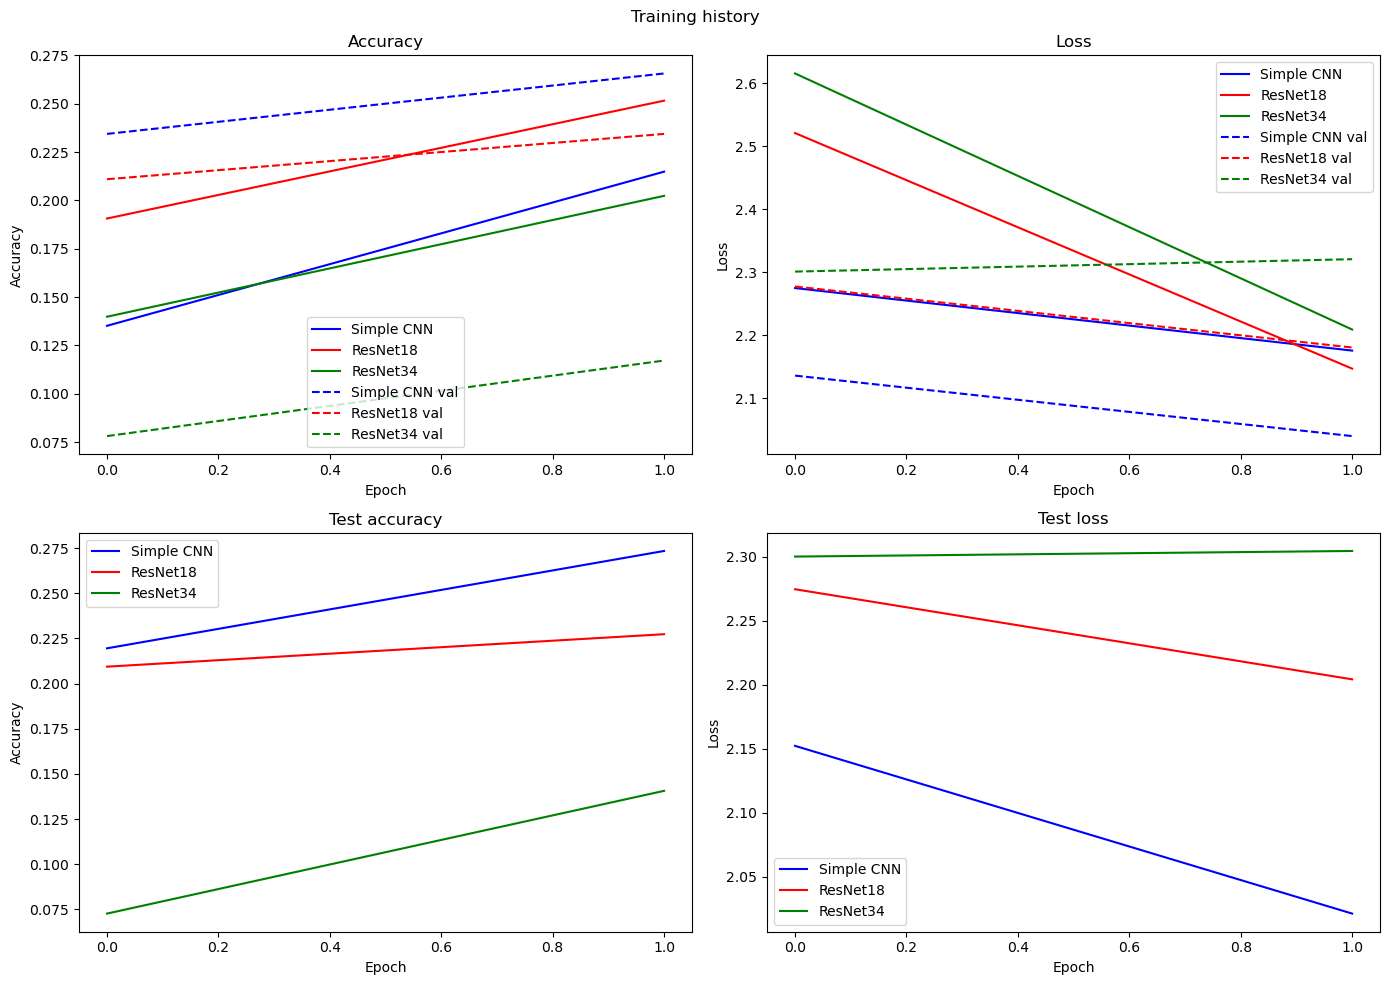

In [ ]:
# plot the training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training history')
# accuracy
axes[0,0].plot(history_sCNN.history['accuracy'], label='Simple CNN', color='b')
axes[0,0].plot(history_res18.history['accuracy'], label='ResNet18', color='r')
axes[0,0].plot(history_res34.history['accuracy'], label='ResNet34', color='g')
axes[0,0].plot(history_sCNN.history['val_accuracy'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,0].plot(history_res18.history['val_accuracy'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,0].plot(history_res34.history['val_accuracy'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,0].set_title('Accuracy')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend()

# loss 
axes[0,1].plot(history_sCNN.history['loss'], label='Simple CNN', color='b')
axes[0,1].plot(history_res18.history['loss'], label='ResNet18', color='r')
axes[0,1].plot(history_res34.history['loss'], label='ResNet34', color='g')
axes[0,1].plot(history_sCNN.history['val_loss'], label='Simple CNN val', linestyle='dashed', color='b')
axes[0,1].plot(history_res18.history['val_loss'], label='ResNet18 val', linestyle='dashed', color='r')
axes[0,1].plot(history_res34.history['val_loss'], label='ResNet34 val', linestyle='dashed', color='g')
axes[0,1].set_title('Loss')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Loss')
axes[0,1].legend()

# test accuracy
axes[1,0].plot(test_res_callback_sCNN.test_results['test_accuracy'], label='Simple CNN', color='b')
axes[1,0].plot(test_res_callback_res18.test_results['test_accuracy'], label='ResNet18', color='r')
axes[1,0].plot(test_res_callback_res34.test_results['test_accuracy'], label='ResNet34', color='g')
axes[1,0].set_title('Test accuracy')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].legend()

# test loss
axes[1,1].plot(test_res_callback_sCNN.test_results['test_loss'], label='Simple CNN', color='b')
axes[1,1].plot(test_res_callback_res18.test_results['test_loss'], label='ResNet18', color='r')
axes[1,1].plot(test_res_callback_res34.test_results['test_loss'], label='ResNet34', color='g')
axes[1,1].set_title('Test loss')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Make a prediction with some test samples
# simple_CNN.load_weights('trained_models/simpleCNN.h5')
# res_net18.load_weights('trained_models/resnet18.h5')
# res_net34.load_weights('trained_models/resnet34.h5')

num_samples = 4
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 5
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns*3, figsize=(fig_width*3, fig_height))
fig.suptitle('Train data samples')
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

dyn_cutout_layer = DynamicCutoutLayer(mask_size = 10, shape='circle', cutout_prob=1.0)
for i, (image, label) in enumerate(test_data.take(num_samples)):
    if (i+1) % 3 == 0:
      continue
    image_saliency = dyn_cutout_layer.get_network_attention(res_net18, (image, label))
    image_cutout = dyn_cutout_layer((image, label), res_net18, training=True)
    axes[i].imshow((image[0] + 1) / 2)
    axes[i+1].imshow((image_saliency[0]+1) / 2)
    axes[i+2].imshow((image_cutout[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    pred_sCNN = simple_CNN.predict(image)
    pred_res18 = res_net18.predict(image)
    pred_res34 = res_net34.predict(image)
    true_label = label_names[np.argmax(label[0])]
    pred_label_sCNN = label_names[np.argmax(pred_sCNN[0])]
    pred_label_res18 = label_names[np.argmax(pred_res18[0])]
    pred_label_res34 = label_names[np.argmax(pred_res34[0])]
    label = f"True: {true_label}\nSimple CNN: {pred_label_sCNN}\nResNet18: {pred_label_res18}\nResNet34: {pred_label_res34}"
    axes[i].set_title(label)
    axes[i+1].set_title('Saliency')
    axes[i+2].set_title('Cutout')
    axes[i].axis('off')
    axes[i+1].axis('off')
    axes[i+2].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined